In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
crops = pd.read_csv("C:/Users/sylwi/OneDrive/Documents/GitHub/Soil_Measures/soil_measures_dc.csv")

In [2]:
# Check for missing values
print(crops.isna().sum().sort_values())

N       0
P       0
K       0
ph      0
crop    0
dtype: int64


In [3]:
print(crops['crop'].value_counts())


crop
rice           100
maize          100
jute           100
cotton         100
coconut        100
papaya         100
orange         100
apple          100
muskmelon      100
watermelon     100
grapes         100
mango          100
banana         100
pomegranate    100
lentil         100
blackgram      100
mungbean       100
mothbeans      100
pigeonpeas     100
kidneybeans    100
chickpea       100
coffee         100
Name: count, dtype: int64


In [4]:
# Check 'crop' column to see if it's a binary or multi-label feature
print(crops['crop'].unique())

['rice' 'maize' 'chickpea' 'kidneybeans' 'pigeonpeas' 'mothbeans'
 'mungbean' 'blackgram' 'lentil' 'pomegranate' 'banana' 'mango' 'grapes'
 'watermelon' 'muskmelon' 'apple' 'orange' 'papaya' 'coconut' 'cotton'
 'jute' 'coffee']


(2200, 4) (2200,)


array([[<Axes: title={'center': 'N'}>, <Axes: title={'center': 'P'}>],
       [<Axes: title={'center': 'K'}>, <Axes: title={'center': 'ph'}>]],
      dtype=object)

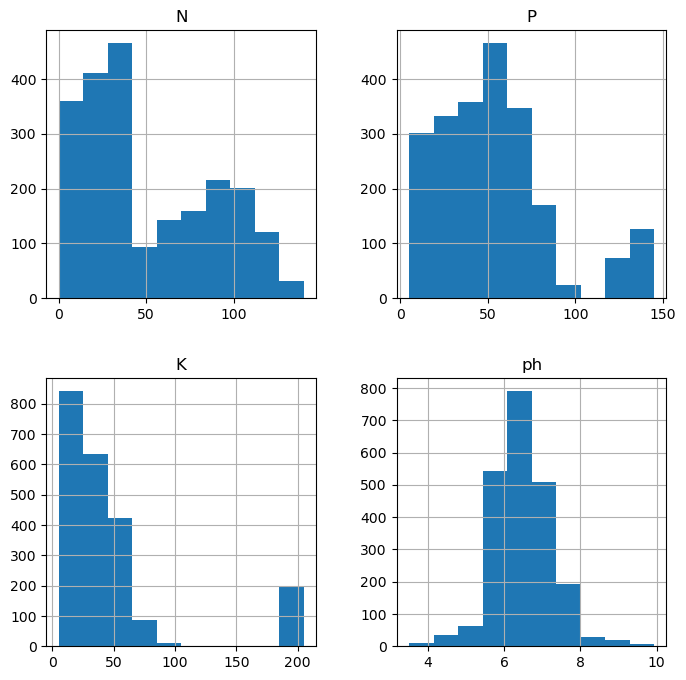

In [5]:
# The crop column is a multi-label feature 
# Create a variable containing all features except for 'crop' column
X = crops.drop(columns = "crop")

# Create a variable containing only the 'crop' column
y = crops["crop"]

# Split into training and test sets to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

# Check the shape of the features and target variables
print(X.shape, y.shape)

crops.hist(figsize=(8,8))

In [6]:
# We can also test normality using the Shapiro-Wilk test 
from scipy.stats import shapiro, kstest

# Exclude 'crop' and apply Shapiro-Wilk test to the remaining features
columns_to_test = crops.columns.difference(['crop'])
shapiro_results = crops[columns_to_test].apply(lambda x: shapiro(x), result_type='expand').T
shapiro_results.columns = ['Statistic', 'p-value']

print(shapiro_results)

    Statistic       p-value
K    0.605532  0.000000e+00
N    0.915396  2.131412e-33
P    0.911168  4.709313e-34
ph   0.979104  1.958969e-17


<Axes: >

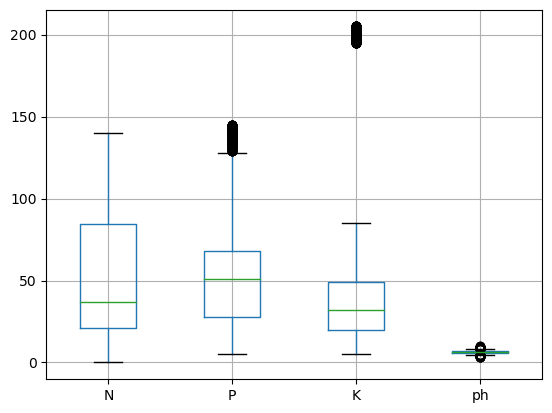

In [7]:
# The above subplots show that N, P, and K follow a right skewed distribution and that pH resembled a normal distribution.
# Similarly, the Shapiro-Wilk test showcases very small p-values for the features indicating that none are normally distributed
# Visualize the distribution of the features using a boxplot
crops.boxplot()

In [8]:
# ph values have a much smaller scale of values in comparison to the other features. P and K also have some outliers
# Check the range of our feature variables in the crops dataset
crops[["N", "K", "P", "ph"]].describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.55,36.92,0.0,21.00,37.00,84.25,140.00
K,2200.0,48.15,50.65,5.0,20.00,32.00,49.00,205.00
P,2200.0,53.36,32.99,5.0,28.00,51.00,68.00,145.00
ph,2200.0,6.47,0.77,3.5,5.97,6.43,6.92,9.94


array([[<Axes: title={'center': 'K'}>, <Axes: title={'center': 'N'}>],
       [<Axes: title={'center': 'P'}>, <Axes: >]], dtype=object)

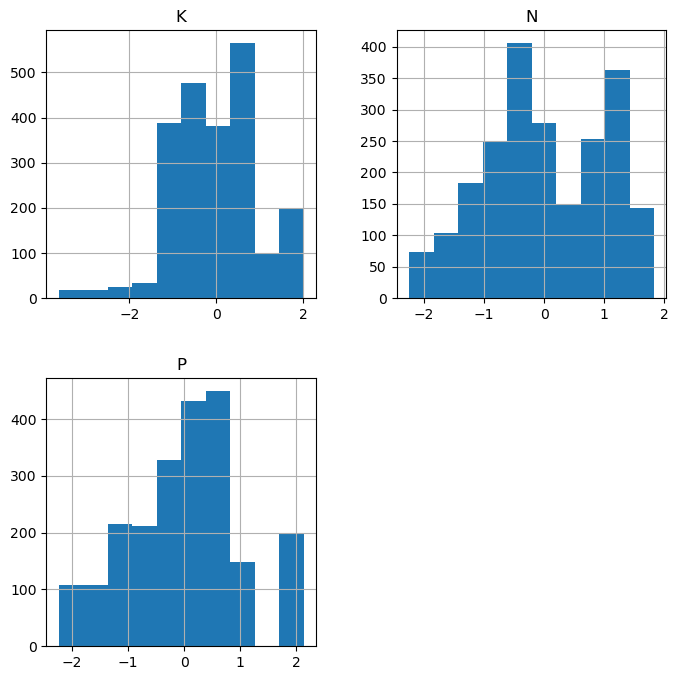

In [9]:
# Let's try to use StandardScaler() on the 3 measures that are comparatively higher in variance to ph
# Given the skewed distribution, we choose to move forward with the PowerTransformer class
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()
crops[["K", "N", "P"]] = pd.DataFrame(pt.fit_transform(crops[["K", "N", "P"]]), columns = ["K", "N", "P"])
crops[["K", "N", "P"]].hist(figsize=(8,8))

In [10]:
# Variance should be close to 1 for normal distribution
crops[["K", "N", "P"]].var()

K    1.000455
N    1.000455
P    1.000455
dtype: float64

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Predict the crop using each feature individually building four models, one for each feature
# Create an empty dictionary to store each features predictive performance
feature_performance = {}

# Loop through features
for feature in ["N", "P", "K", "ph"]:
    # Due to convergence warning, instantiate a StandardScaler object
    scaler = StandardScaler()
    # Construct a list of steps containing tuples with step names specificed as string
    # Create model ensuring multi-class predicition is supported
    #("scaler", StandardScaler(),
    steps = [("scaler", StandardScaler()),
            ("log_reg", LogisticRegression(multi_class="multinomial", solver="saga"))]
    # Impute using a pipeline, which is an object used to run a series of transformations and build a model in a single owrkflow
    pipeline = Pipeline(steps)
    # Fit the model to the feature in X_train but subsetting it using single square brackets
    log_reg_scaled = pipeline.fit(X_train[[feature]], y_train)
    # Predict target values using the test set and storing results in y_pred
    y_pred = log_reg_scaled.predict(X_test[[feature]])
    # Calculate ROC AUC scores
    preds = log_reg_scaled.predict_proba(X_test[[feature]])
    roc_auc = roc_auc_score(y_test, preds, multi_class="ovr")
    feature_performance[feature] = roc_auc
    print(f"ROC AUC score for {feature}: {roc_auc}")
    
    # Calculate F1 score, the harmonic mean of precision and recall
    f1 = f1_score(y_test, y_pred, average="weighted")
    # Add F1 score pairs to the dictionary
    feature_performance[feature] = f1
    print(f"F1-score for {feature}: {f1}")
    

ROC AUC score for N: 0.8234851253572312
F1-score for N: 0.07597350285728291
ROC AUC score for P: 0.875766488935893
F1-score for P: 0.11295396163044077
ROC AUC score for K: 0.8802017909381231
F1-score for K: 0.13622076698553245
ROC AUC score for ph: 0.7006283923567366
F1-score for ph: 0.03842281397167993


C:\Users\sylwi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


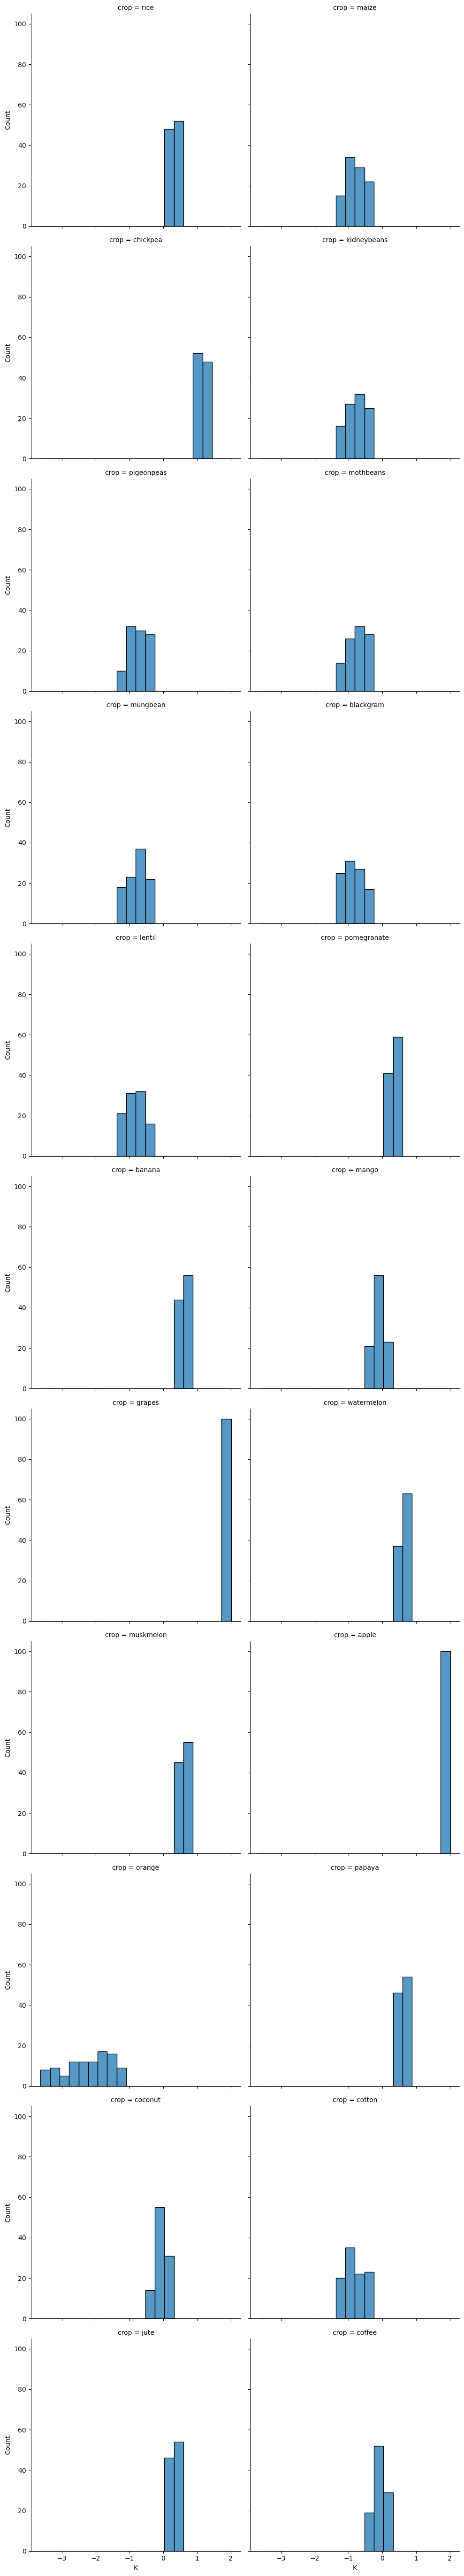

In [28]:
# Based on the F1-scores above, K (Potassium) is the feature with the strongest predictive performance for classifying crops types, with an F1 score of 0.1085. The others have lower F1 scores indicating poor predictive peformance, in order of decreasing performance: P, N, ph
sns.displot(data=crops, x='K', col='crop', col_wrap=2, bins=20)
plt.show()

In [30]:
crop_stats = crops.groupby("crop")["K"].mean()
print(crop_stats)

crop
apple          1.991532
banana         0.622299
blackgram     -0.828183
chickpea       1.166142
coconut       -0.059046
coffee        -0.093208
cotton        -0.798243
grapes         1.992365
jute           0.326391
kidneybeans   -0.754021
lentil        -0.808810
maize         -0.773751
mango         -0.093292
mothbeans     -0.737194
mungbean      -0.770815
muskmelon      0.623426
orange        -2.185830
papaya         0.622672
pigeonpeas    -0.727834
pomegranate    0.334943
rice           0.323628
watermelon     0.626829
Name: K, dtype: float64


In [38]:
# Convert crop to categorical data type
crops['crop'] = pd.Categorical(crops['crop'])

In [37]:
from statsmodels.formula.api import ols
crops_model = ols("K ~ crop", data=crops).fit()
print(crops_model.params)

Intercept              1.991532
crop[T.banana]        -1.369233
crop[T.blackgram]     -2.819714
crop[T.chickpea]      -0.825390
crop[T.coconut]       -2.050578
crop[T.coffee]        -2.084740
crop[T.cotton]        -2.789775
crop[T.grapes]         0.000833
crop[T.jute]          -1.665141
crop[T.kidneybeans]   -2.745553
crop[T.lentil]        -2.800342
crop[T.maize]         -2.765283
crop[T.mango]         -2.084823
crop[T.mothbeans]     -2.728726
crop[T.mungbean]      -2.762347
crop[T.muskmelon]     -1.368106
crop[T.orange]        -4.177362
crop[T.papaya]        -1.368860
crop[T.pigeonpeas]    -2.719365
crop[T.pomegranate]   -1.656589
crop[T.rice]          -1.667904
crop[T.watermelon]    -1.364703
dtype: float64
